In [10]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive
import os
os.chdir('drive/Colab Notebooks')
print(os.getcwd())

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
 CNN.ipynb  'Colab Notebooks'   delta.ipynb  'dif&surf.ipynb'
/content/drive/Colab Notebooks


In [0]:
import torch
import os

import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

CLASS_NUM = 5

In [0]:
def paddleDataFrame(df):
    df_cpy = df.copy()
    amp = int((1000/len(df)))
    for i in range(amp):
        df_cpy = pd.concat([df_cpy, df])
    return df_cpy

def SURFdataTransform(data):
    # paddle & cut
    if len(data) < 1000:
        data = paddleDataFrame(data)
    data = data.sort_values(by='response', ascending=False).head(1000)
    # normalization, log normalization for response
    data.x =  MinMaxScaler().fit_transform(data.x.astype('float').values.reshape((-1, 1)))
    data.y =  MinMaxScaler().fit_transform(data.y.astype('float').values.reshape((-1, 1)))
    data['size'] =  MinMaxScaler().fit_transform(data['size'].astype('float').values.reshape((-1, 1)))
    data.response =  np.log(data.response)
    data.response =  MinMaxScaler().fit_transform(data.response.astype('float').values.reshape((-1, 1)))

    # standardization
    data.x =  StandardScaler(with_mean=False).fit_transform(data.x.astype('float').values.reshape((-1, 1)))
    data.y =  StandardScaler(with_mean=False).fit_transform(data.y.astype('float').values.reshape((-1, 1)))
    data['size'] =  StandardScaler(with_mean=False).fit_transform(data['size'].astype('float').values.reshape((-1, 1)))
    data.response =  StandardScaler(with_mean=False).fit_transform(data.response.astype('float').values.reshape((-1, 1)))

    return data

class SURFDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform = None):
        self.transform = transform
        dir_list = os.listdir(root_dir)
        dir_list.sort()
        self.class_to_idx = dict(zip(dir_list, range(0, len(dir_list))))
        self.datasets = []
        for i in dir_list:
            idx = dir_list.index(i)
            path = os.path.join(root_dir, i)
            files = os.listdir(path)
            for j in files:
                sample = {}
                csv = pd.read_csv(os.path.join(path, j))
                sample['data'] = SURFdataTransform(csv).values
                sample['target'] = idx
                self.datasets.append(sample)

    def __len__(self):
        return len(self.datasets)

    def __getitem__(self, idx):
        sample = self.datasets[idx]
        sample['data'] = torch.as_tensor(sample['data'])
        sample['target'] = torch.as_tensor(sample['target'])
        return sample

In [0]:
class DNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dp = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4*1000, 100)
        self.fc2 = nn.Linear(100, 1000)
        self.fc3 = nn.Linear(1000, 20)
        self.fc4 = nn.Linear(20, CLASS_NUM)
        self.actv = nn.Tanh()

    def forward(self, x):
        x = x.view(1, -1)
        x = self.actv(self.dp(self.fc1(x)))
        x = self.actv(self.dp(self.fc2(x)))
        x = self.actv(self.fc3(x))
        x = self.fc4(x)
        return x

In [101]:
if __name__ == '__main__':
    plt.ion()
    if_cuda = True

    transform = None

    train_dataset = SURFDataset('data1/train/', transform = transform)
    val_dataset = SURFDataset('data1/val/', transform = transform)
    test_dataset = SURFDataset('data1/test/', transform = transform) + val_dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    print(train_dataset.class_to_idx)

{'Agent': 0, 'Dofloo': 1, 'Lady': 2, 'Mayday': 3, 'normal': 4}


In [102]:
    model = DNN_Model()
    epo = 200

    if if_cuda: 
        model.cuda()
        loss_function = nn.CrossEntropyLoss().cuda()
    else:
        loss_function = nn.CrossEntropyLoss()

    # optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay= 1e-5, momentum = 0.1, nesterov = True)
    optimizer = optim.Adam(model.parameters(), lr=5e-6, betas=(0.9, 0.999))
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []

    for epoch in range(epo):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []

        model.train()
        for i in train_loader:
            data = i['data']
            target = i['target']
            if if_cuda: 
                data = data.cuda()
                target = target.cuda()
            optimizer.zero_grad()
            output = model(data.float())
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            pre = output.argmax(dim=1)
            train_acc.append(pre.item() == target.item())

        model.eval()
        for i in val_loader:
            data = i['data']
            target = i['target']
            if if_cuda: 
                data = data.cuda()
                target = target.cuda()
            output = model(data.float())
            loss = loss_function(output, target)
            valid_loss.append(loss.item())
            pre = output.argmax(dim=1)
            valid_acc.append(pre.item() == target.item())
        if epoch % 10 == 0:
            print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss), "Train Accuracy: ", np.mean(train_acc), "Valid Accuracy: ", np.mean(valid_acc))
        train_loss_list.append(np.mean(train_loss))
        valid_loss_list.append(np.mean(valid_loss))
        train_acc_list.append(np.mean(train_acc))
        valid_acc_list.append(np.mean(valid_acc))

Epoch: 0 Training Loss:  1.533798485994339 Valid Loss:  1.4332197958772832 Train Accuracy:  0.4642857142857143 Valid Accuracy:  0.6363636363636364
Epoch: 10 Training Loss:  1.4126162401267461 Valid Loss:  1.2189178006215529 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 20 Training Loss:  1.320964549268995 Valid Loss:  1.1786445866931567 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 30 Training Loss:  1.2499519096953529 Valid Loss:  1.1570929343050176 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 40 Training Loss:  1.1976603120565414 Valid Loss:  1.1393897316672585 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 50 Training Loss:  1.1702708346503121 Valid Loss:  1.1294863278215581 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 60 Training Loss:  1.1226762171302522 Valid Loss:  1.1179238232699307 Train Accuracy:  0.5714285714285

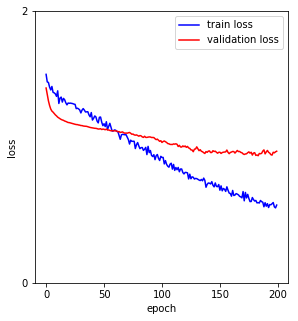

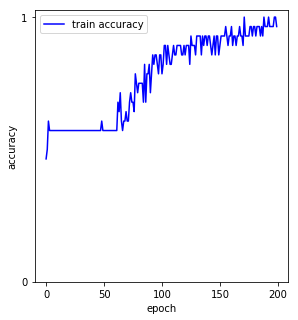

In [103]:
x = range(epo)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
l1, = plt.plot(x, train_loss_list, '-b')
l2, = plt.plot(x, valid_loss_list, '-r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([l1, l2], ['train loss', 'validation loss'], loc='best')
plt.yticks([0, 2])
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 2)
l1, = plt.plot(x, train_acc_list, '-b')
# l2, = plt.plot(x, valid_acc_list, '-r')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend([l1, l2], ['train acc', 'validation acc'], loc='best')
plt.legend([l1], ['train accuracy'], loc='best')
plt.yticks([0, 1])
plt.ylabel('accuracy')

plt.show()

In [104]:
    
    accuracy = []
    for i in test_loader:
        data = i['data']
        target = i['target']
        if if_cuda: 
            data = data.cuda()
            target = target.cuda()
        output = model(data.float())
        pre = output.argmax(dim=1)
        print(pre.item(), target.item(), pre.item() == target.item())
        accuracy.append(pre.item() == target.item())
    print(np.mean(accuracy))

4 4 True
4 3 False
4 4 True
4 3 False
4 4 True
4 0 False
4 4 True
4 4 True
4 4 True
2 1 False
4 4 True
1 4 False
4 4 True
4 4 True
4 1 False
4 4 True
4 4 True
4 4 True
4 0 False
4 2 False
1 2 False
4 4 True
0.5909090909090909
